In [ ]:
!rm -rf genetic_algorithms_8_queens # REMOVE PASTA PRA DAR UPDATE, NAO USEM O CODIGO DO GIT, TOU DANDO CLONE SÓ PELAS FUNÇÕES DE BENCHMARK
!git clone https://github.com/LucasAbsalao/genetic_algorithms_8_queens.git


Cloning into 'genetic_algorithms_8_queens'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 71 (delta 25), reused 52 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 253.27 KiB | 10.55 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
import sys
sys.path.append('/content/genetic_algorithms_8_queens/otimizacao')

# Algoritmos Genéticos

=== Otimizando função Ackley ===
=== Otimizando função Rastrigin ===
=== Otimizando função Schwefel ===
=== Otimizando função Rosenbrock ===


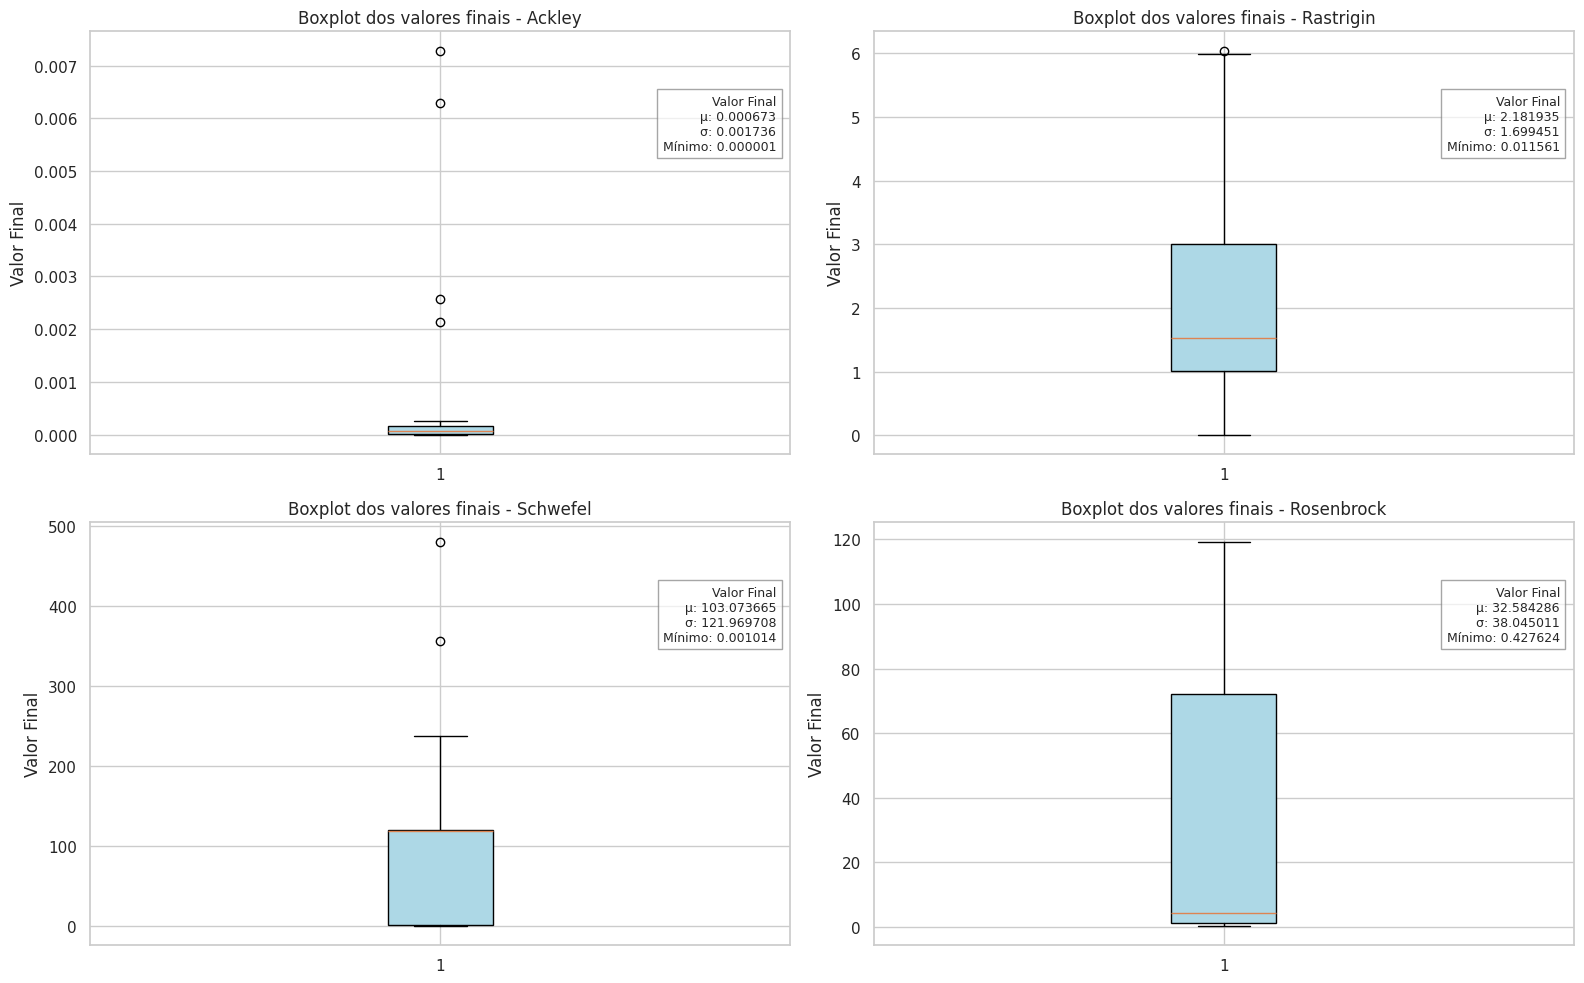

In [ ]:
%matplotlib inline
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from benchmark_functions import *

# --------- HIPERPARÂMETROS POR FUNÇÃO ---------
FUNCTION_CONFIGS = {
    ackley: {
        'name': 'Ackley',
        'domain': (ACKLEY_MIN_LIMIT, ACKLEY_MAX_LIMIT),
        'pop_size': 80,
        'genes': 30,
        'mutation_prob': 0.01,
        'generations': 500,
        'runs': 30,
        'sigma': 0.1,
        'tournament_k': 3,
        'alpha': 0.5
    },
    rastrigin: {
        'name': 'Rastrigin',
        'domain': (RASTRIGIN_MIN_LIMIT, RASTRIGIN_MAX_LIMIT),
        'pop_size': 50,
        'genes': 30,
        'mutation_prob': 0.01,
        'generations': 700,
        'runs': 30,
        'sigma': 0.05,
        'tournament_k': 5,
        'alpha': 0.6
    },
    schwefel: {
        'name': 'Schwefel',
        'domain': (SCHWEFEL_MIN_LIMIT, SCHWEFEL_MAX_LIMIT),
        'pop_size': 80,
        'genes': 30,
        'mutation_prob': 0.03,
        'generations': 800,
        'runs': 30,
        'sigma': 0.3,
        'tournament_k': 9,
        'alpha': 0.9
    },
    rosenbrock: {
        'name': 'Rosenbrock',
        'domain': (ROSENBROCK_MIN_LIMIT, ROSENBROCK_MAX_LIMIT),
        'pop_size': 100,
        'genes': 30,
        'mutation_prob': 0.05,
        'generations': 1000,
        'runs': 30,
        'sigma': 0.01,
        'tournament_k': 3,
        'alpha': 0.2
    },
}

# --------- FUNÇÕES GENÉTICAS ---------
def generate_population(cfg):
    dmin, dmax = cfg['domain']
    return np.random.uniform(dmin, dmax, (cfg['pop_size'], cfg['genes']))

def fitness(pop, f):
    return np.apply_along_axis(f, 1, pop)

def tournament_selection(pop, fitness_scores, cfg):
    size = cfg['pop_size']
    k = cfg['tournament_k']
    idxs = np.random.randint(0, size, size=(size, k))
    selected = np.argmin(fitness_scores[idxs], axis=1)
    return pop[idxs[np.arange(size), selected]]

def crossover_blend(p1, p2, alpha):
    diff = np.abs(p1 - p2)
    min_vals = np.minimum(p1, p2) - alpha * diff
    max_vals = np.maximum(p1, p2) + alpha * diff
    return np.random.uniform(min_vals, max_vals)

def apply_crossover(parents, cfg):
    dmin, dmax = cfg['domain']
    size = cfg['pop_size']
    alpha = cfg['alpha']
    np.random.shuffle(parents)
    offspring = np.empty_like(parents)
    for i in range(0, size, 2):
        if i+1 < size:
            c1 = np.clip(crossover_blend(parents[i], parents[i+1], alpha), dmin, dmax)
            c2 = np.clip(crossover_blend(parents[i+1], parents[i], alpha), dmin, dmax)
            offspring[i], offspring[i+1] = c1, c2
    return offspring

def mutate_gaussian(pop, cfg):
    dmin, dmax = cfg['domain']
    sigma = cfg['sigma'] * (dmax - dmin)
    mutation_prob = cfg['mutation_prob']
    mutation_mask = np.random.rand(*pop.shape) < mutation_prob
    mutations = np.random.normal(0, sigma, size=pop.shape)
    mutated_pop = pop + mutation_mask * mutations
    return np.clip(mutated_pop, dmin, dmax)

# --------- ALGORITMO GENÉTICO ---------
def genetic_algorithm(f, cfg):
    pop = generate_population(cfg)
    fit = fitness(pop, f)
    best_idx = np.argmin(fit)
    best_ind = pop[best_idx].copy()
    best_fit = fit[best_idx]
    history = []

    for _ in range(cfg['generations']):
        parents = tournament_selection(pop, fit, cfg)
        offspring = apply_crossover(parents, cfg)
        offspring = mutate_gaussian(offspring, cfg)
        offspring_fit = fitness(offspring, f)

        # elitismo
        worst_idx = np.argmax(offspring_fit)
        if best_fit < offspring_fit[worst_idx]:
            offspring[worst_idx] = best_ind
            offspring_fit[worst_idx] = best_fit

        pop = offspring
        fit = offspring_fit

        cur_best_idx = np.argmin(fit)
        if fit[cur_best_idx] < best_fit:
            best_fit = fit[cur_best_idx]
            best_ind = pop[cur_best_idx].copy()

        history.append(best_fit)

    return best_ind, best_fit, history

# --------- EXECUÇÃO E VISUALIZAÇÃO ---------
def main():
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    sns.set_theme(style="whitegrid")
    axes = axes.flatten()

    for i, (func, cfg) in enumerate(FUNCTION_CONFIGS.items()):
        print(f"=== Otimizando função {cfg['name']} ===")

        global_best_val = float('inf')
        global_best = None
        runs = []

        for _ in range(cfg['runs']):
            best_ind, val, history = genetic_algorithm(func, cfg)
            runs.append(val)
            if val < global_best_val:
                global_best = best_ind
                global_best_val = val

        ax = axes[i]
        # Boxplot dos valores finais das runs
        ax.boxplot(runs, patch_artist=True, boxprops=dict(facecolor="lightblue"))
        ax.set_title(f"Boxplot dos valores finais - {cfg['name']}")
        ax.set_ylabel("Valor Final")

        average = np.mean(runs)
        deviation = np.std(runs)

        stats_text = (
            "Valor Final\n"
            f"µ: {average:.6f}\n"
            f"σ: {deviation:.6f}\n"
            f"Mínimo: {global_best_val:.6f}"
        )
        ax.text(0.98, 0.85, stats_text,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()

#Estratégia Evolutiva

In [ ]:
FUNCTION_CONFIGS = {
    ackley : {
        'name' : 'ackley',
        'runs' : 30,
        'generations' : 150,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.1,
        'tau_l_factor' : 0.2,
        'sigma_max' : 2,
        'sigma_factor' : 0.001
    },
    rastrigin : {
        'name' : 'rastrigin',
        'runs' : 30,
        'generations' : 150,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.1,
        'tau_l_factor' : 0.2,
        'sigma_max' : 3,
        'sigma_factor' : 0.001
    },
    schwefel : {
        'name' : 'schwefel',
        'runs' : 30,
        'generations' : 150,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.005,
        'tau_l_factor' : 0.01,
        'sigma_max' : 3,
        'sigma_factor' : 0.001
    },
    rosenbrock : {
        'name' : 'rosenbrock',
        'runs' : 30,
        'generations' : 700,
        'population' : 100,
        'lambda' : 500,
        'tau_factor' : 0.1,
        'tau_l_factor' : 0.01,
        'sigma_max' : 3,
        'sigma_factor' : 0.0001
    },

}

In [ ]:
def normalize(x,min,max):
    return min + x*(max - min)

class Individual():
    def __init__(self, dimension_genes, parameter_genes, fitness_function, min_range:int = -1, max_range:int = 1, tau_factor:float = 1, tau_l_factor:float = 1, sigma_max:float=4):
        self.min = min_range
        self.max = max_range
        if len(dimension_genes) != len(parameter_genes):
            raise Exception("Tamanho do vetor de dimensões e de sigma devem ser iguais")
        self.dimension_genes = np.array(dimension_genes, dtype = np.float64)
        self.parameter_genes = np.array(parameter_genes, dtype = np.float64)
        self.fitness_function = fitness_function
        self.fitness = self.calculate_fitness()


        self.tau_l = tau_l_factor*(1 / np.sqrt(2*len(dimension_genes)))
        self.tau = tau_factor*(1 / np.sqrt(2*np.sqrt(len(dimension_genes))))
        self.sigma_max = (max_range-min_range) * sigma_max
        self.epsilon = (max_range-min_range) * 10**-12

    def __str__(self):
        return str(self.dimension_genes)

    def __repr__(self):
        return self.__str__()


    def calculate_fitness(self):
        return -self.fitness_function(self.dimension_genes)

    def is_valid_solution(self):
        return True if self.fitness == 0 else False

    def mutate(self):
        global_normal = np.random.normal(0,1)
        for i in range(len(self.dimension_genes)):
            lognormal = np.exp(self.tau_l * global_normal + self.tau * np.random.normal(0,1))
            sigma_l = self.parameter_genes[i] * lognormal
            sigma_l = min(max(sigma_l, self.epsilon), self.sigma_max)
            self.parameter_genes[i] = sigma_l

        for i in range(len(self.dimension_genes)):
            x_l = self.dimension_genes[i]
            count = 0

            # Tenta até 10 vezes gerar um valor dentro dos limites
            while count < 10:
                new_x = x_l + self.parameter_genes[i] * np.random.normal(0,1)
                if self.min <= new_x <= self.max:
                    x_l = new_x
                    break
                count += 1
            else:
                new_x = x_l + self.parameter_genes[i] * np.random.normal(0,1)
                if new_x > self.max:
                    x_l = 2 * self.max - new_x
                elif new_x < self.min:
                    x_l = 2 * self.min - new_x
                else:
                    x_l = new_x

            self.dimension_genes[i] = x_l

        self.fitness = self.calculate_fitness()


class Population():
    def __init__(self, dimensions, size_population, qtt_childs, fitness_function, min_range:int = -1, max_range:int = 1, tau_factor:float = 1, tau_l_factor:float = 1, sigma_max:float = 4, sigma_factor:float = 0.01):
        self.individuals = []
        self.qtt_childs = qtt_childs
        self.fitness_function = fitness_function
        self.min_range = min_range
        self.max_range = max_range
        self.dimensions = dimensions
        self.tau_factor = tau_factor
        self.tau_l_factor = tau_l_factor
        self.sigma_factor = sigma_factor
        self.sigma_max = sigma_max

        self.all_mean = []
        self.all_stdev = []
        self.all_best_ind = []
        self.sigmas_mean = []

        for _ in range(size_population):
            dimension_genes = np.random.rand(dimensions)
            parameter_genes = np.ones(dimensions)*(self.max_range-self.min_range)*sigma_factor

            dimension_genes = normalize(dimension_genes, self.min_range, self.max_range)
            self.individuals.append(Individual(dimension_genes,parameter_genes, fitness_function, min_range, max_range, tau_factor, tau_l_factor, sigma_max))

        # print("------HiperParâmetros-------")
        # print(f"size_population: {size_population}")
        # print(f"qtt_childs: {self.qtt_childs}")
        # print(f"tau_factor: {self.tau_factor}")
        # print(f"tau_l_factor: {self.tau_l_factor}")
        # print(f"sigma_factor: {self.sigma_factor}")
        # print(f"sigma_max: {self.sigma_max}")

    def global_recombination(self):
        dimension_genes = []
        parameter_genes = []
        for i in range(self.dimensions):
            pai1 = random.choice(self.individuals)
            pai2 = random.choice(self.individuals)
            if random.random()>0.5:
                dimension_genes.append(pai1.dimension_genes[i])
            else:
                dimension_genes.append(pai2.dimension_genes[i])

            parameter_genes.append((pai1.parameter_genes[i] + pai2.parameter_genes[i])/2)

        return Individual(dimension_genes, parameter_genes, self.fitness_function, self.min_range, self.max_range, self.tau_factor, self.tau_l_factor, self.sigma_max)

    def select_individuals(self, offspring):
        return sorted(offspring, key=lambda x: x.fitness, reverse=True)

    def melhor_individuo(self):
        return max(self.individuals, key=lambda x: x.fitness)

    def fitness_media(self):
        return np.mean([individual.fitness for individual in self.individuals])

    def fitness_stdev(self):
        return statistics.stdev([individual.fitness for individual in self.individuals])

    def optimize(self, generations:int):
        generation = 0
        with tqdm(range(generations), desc=f"Optimizing {self.fitness_function.__name__} function") as bar:
            for g in bar:
                childs = []
                for _ in range(self.qtt_childs):
                    child = self.global_recombination()
                    child.mutate()
                    childs.append(child)

                #childs.extend(self.individuals)
                childs = self.select_individuals(childs)[:len(self.individuals)]
                self.individuals = childs

                self.all_mean.append(self.fitness_media())
                self.all_stdev.append(self.fitness_stdev())
                self.all_best_ind.append(self.melhor_individuo().fitness)
                self.sigmas_mean.append(np.mean([np.mean(ind.parameter_genes) for ind in self.individuals]))

                bar.set_postfix({
                    "best_ind": f"{self.melhor_individuo().fitness:.6f}",
                    "mean_sigma": f"{self.sigmas_mean[-1]:.6f}"
                })

                generation+=1

        return self.melhor_individuo(), self.melhor_individuo().fitness, self.all_best_ind


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_theme(style="whitegrid")
axes = axes.flatten()

for i, (func, cfg) in enumerate([(rosenbrock, FUNCTION_CONFIGS[rosenbrock])]):
    print(f"=== Otimizando função {cfg['name']} ===")

    global_best_val = float('inf')
    global_best = None
    run_history = []
    runs = []

    for _ in range(cfg['runs']):
        pop = Population(30, 100, 100*5, rastrigin, RASTRIGIN_MIN_LIMIT, RASTRIGIN_MAX_LIMIT, tau_factor = cfg['tau_factor'], tau_l_factor = cfg['tau_l_factor'], sigma_max=cfg['sigma_max'],sigma_factor = cfg['sigma_factor'])
        best_ind, val, history = pop.optimize(cfg['generations'])
        runs.append(val)
        run_history.append(history)

        if val < global_best_val:
            global_best = best_ind
            global_best_val = val

    average = np.mean(runs)
    deviation = np.std(runs)
    gens = np.arange(cfg['generations'])

    run_history = np.array(run_history)
    mean_curve = np.mean(run_history, axis=0)
    std_curve = np.std(run_history, axis=0)

    ax = axes[i]
    ax.plot(gens, mean_curve, label="Média", color="blue")
    ax.fill_between(gens, mean_curve - std_curve, mean_curve + std_curve,
                    color="blue", alpha=0.3, label="Desvio Padrão")
    ax.set_title(f"Convergência - {cfg['name']}")
    ax.set_xlabel("Geração")
    ax.set_ylabel("Valor")
    ax.legend(loc="upper right", fontsize=9)

    stats_text = (
        "Valor Final\n"
        f"µ: {average:.6f}\n"
        f"σ: {deviation:.6f}\n"
        f"Mínimo: {global_best_val:.6f}"
    )
    ax.text(0.98, 0.85, stats_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()
